# Múltiplos Schemas

## Revisão

Acabamos de cobrir schema de estado e reducers de estado.

Tipicamente, todos os nós do grafo se comunicam com um único schema.

Além disso, este schema único contém as chaves/canais de entrada e saída do grafo.

## Objetivos

Mas existem casos em que podemos querer um pouco mais de controle sobre isso:

* Nós internos podem passar informações que *não são necessárias* na entrada/saída do grafo.

* Também podemos querer usar diferentes schemas de entrada/saída para o grafo. A saída pode, por exemplo, conter apenas uma única chave relevante.

Vamos discutir algumas maneiras de personalizar grafos com múltiplos schemas.

In [44]:
%%capture --no-stderr
%pip install --quiet -U langgraph

## Estado Privado

Primeiro, vamos cobrir o caso de passar [estado privado](https://langchain-ai.github.io/langgraph/how-tos/pass_private_state/) entre nós.

Isso é útil para qualquer coisa necessária como parte da lógica intermediária de funcionamento do grafo, mas que não é relevante para a entrada ou saída geral do grafo.

Vamos definir um `OverallState` e um `PrivateState`.

O `node_2` usa `PrivateState` como entrada, mas escreve para `OverallState`.

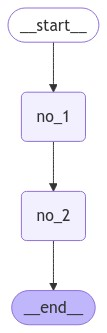

In [45]:
from typing_extensions import TypedDict
from IPython.display import Image, display
from langgraph.graph import StateGraph, START, END

class EstadoGeral(TypedDict):
    foo: int

class EstadoPrivado(TypedDict):
    baz: int

def no_1(estado: EstadoGeral) -> EstadoPrivado:
    print("---Nó 1---")
    return {"baz": estado['foo'] + 1}

def no_2(estado: EstadoPrivado) -> EstadoGeral:
    print("---Nó 2---")
    return {"foo": estado['baz'] + 1}

# Construir grafo
construtor = StateGraph(EstadoGeral)
construtor.add_node("no_1", no_1)
construtor.add_node("no_2", no_2)

# Lógica
construtor.add_edge(START, "no_1")
construtor.add_edge("no_1", "no_2")
construtor.add_edge("no_2", END)

# Adicionar
grafo = construtor.compile()

# Visualizar
display(Image(grafo.get_graph().draw_mermaid_png()))

In [46]:
grafo.invoke({"foo": 1})

---Nó 1---
---Nó 2---


{'foo': 3}

`baz` está incluído apenas no `EstadoPrivado`.

O `no_2` usa `EstadoPrivado` como entrada, mas escreve para `EstadoGeral`.

Assim, podemos ver que `baz` é excluído da saída do grafo porque não está no `EstadoGeral`.

## Schema de Entrada / Saída

Por padrão, `StateGraph` recebe um único schema e espera-se que todos os nós se comuniquem com esse schema.

No entanto, também é possível [definir schemas explícitos de entrada e saída para um grafo](https://langchain-ai.github.io/langgraph/how-tos/input_output_schema/?h=input+outp).

Frequentemente, nesses casos, definimos um schema "interno" que contém *todas* as chaves relevantes para as operações do grafo.

Mas, usamos schemas específicos de `input` e `output` para restringir a entrada e saída.

Primeiro, vamos executar o grafo com um único schema.

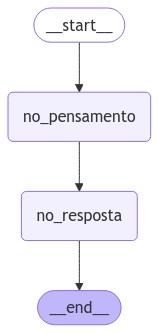

In [47]:
class EstadoGeral(TypedDict):
    pergunta: str
    resposta: str
    notas: str

def no_pensamento(estado: EstadoGeral):
    return {"resposta": "tchau", "notas": "... seu nome é Anderson"}

def no_resposta(estado: EstadoGeral):
    return {"resposta": "tchau Anderson"}

grafo = StateGraph(EstadoGeral)
grafo.add_node("no_resposta", no_resposta)
grafo.add_node("no_pensamento", no_pensamento)
grafo.add_edge(START, "no_pensamento")
grafo.add_edge("no_pensamento", "no_resposta")
grafo.add_edge("no_resposta", END)

grafo = grafo.compile()

# Visualizar
display(Image(grafo.get_graph().draw_mermaid_png()))

Observe que a saída do invoke contém todas as chaves do `EstadoGeral`.

In [48]:
grafo.invoke({"pergunta": "oi"})

{'pergunta': 'oi',
 'resposta': 'tchau Anderson',
 'notas': '... seu nome é Anderson'}

Agora, vamos usar um schema específico de `input` e `output`.

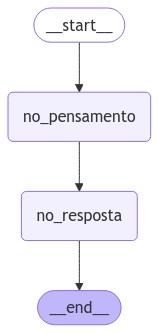

{'resposta': 'Aqui está sua resposta processada'}


In [49]:
from typing_extensions import TypedDict
from IPython.display import Image, display
from langgraph.graph import StateGraph, START, END

# Definição dos schemas
class EstadoEntrada(TypedDict):
    pergunta: str

class EstadoSaida(TypedDict):
    resposta: str

class EstadoGeral(TypedDict):
    pergunta: str
    resposta: str
    notas: str

# Definição dos nós do grafo
def no_pensamento(estado: EstadoGeral):
    return {
        "resposta": "Você fez uma pergunta", 
        "notas": "... processando informações do usuário"
    }

def no_resposta(estado: EstadoSaida):
    return {
        "resposta": "Aqui está sua resposta processada"
    }

# Construção do grafo com schemas explícitos
grafo = StateGraph(
    EstadoGeral,    # Schema interno para processamento
    input=EstadoEntrada,  # Schema de entrada
    output=EstadoSaida    # Schema de saída
)

# Adicionando nós ao grafo
grafo.add_node("no_resposta", no_resposta)
grafo.add_node("no_pensamento", no_pensamento)

# Definindo as conexões do grafo
grafo.add_edge(START, "no_pensamento")
grafo.add_edge("no_pensamento", "no_resposta")
grafo.add_edge("no_resposta", END)

# Compilando o grafo
grafo = grafo.compile()

# Visualizando o grafo
display(Image(grafo.get_graph().draw_mermaid_png()))

# Testando o grafo
resultado = grafo.invoke({"pergunta": "Qual é a sua pergunta?"})
print(resultado)  # Vai mostrar apenas a resposta, conforme definido no EstadoSaida

Podemos ver que o schema de `output` restringe a saída apenas para a chave `resposta`.

## Mais um exemplo: 

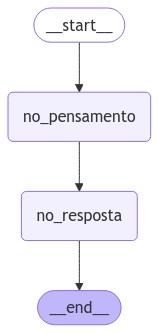

{'resposta': 'Anderson estudou na USP - Universidade de São Paulo'}


In [50]:
class EstadoEntrada(TypedDict):
    pergunta: str

class EstadoSaida(TypedDict):
    resposta: str

class EstadoGeral(TypedDict):
    pergunta: str
    resposta: str
    notas: str

def no_pensamento(estado: EstadoGeral):
    return {
        "resposta": "Você estudou na USP", 
        "notas": "... Anderson estudou na Universidade de São Paulo"
    }

def no_resposta(estado: EstadoSaida):
    return {"resposta": "Anderson estudou na USP - Universidade de São Paulo"}

# Construção do grafo com schemas explícitos
grafo = StateGraph(
    EstadoGeral,    # Schema interno para processamento
    input=EstadoEntrada,  # Schema de entrada
    output=EstadoSaida    # Schema de saída
)

grafo.add_node("no_resposta", no_resposta)
grafo.add_node("no_pensamento", no_pensamento)
grafo.add_edge(START, "no_pensamento")
grafo.add_edge("no_pensamento", "no_resposta")
grafo.add_edge("no_resposta", END)

grafo = grafo.compile()

# Visualizar
display(Image(grafo.get_graph().draw_mermaid_png()))

# Testar o grafo
resultado = grafo.invoke({"pergunta": "Onde você estudou?"})
print(resultado)  # Vai mostrar: {'resposta': 'Anderson estudou na USP - Universidade de São Paulo'}

Outro exemplo: 

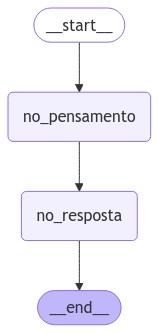

{'resposta': 'A Scoras Academy é a primeira plataforma de cursos dedicada a Agentes de IA  e Small Language Models no Brasil'}


In [51]:
class EstadoEntrada(TypedDict):
    pergunta: str

class EstadoSaida(TypedDict):
    resposta: str

class EstadoGeral(TypedDict):
    pergunta: str
    resposta: str
    notas: str

def no_pensamento(estado: EstadoGeral):
    return {
        "resposta": "A Scoras Academy é pioneira", 
        "notas": "... primeira plataforma especializada em Agentes de IA e Small Language Models no Brasil"
    }

def no_resposta(estado: EstadoSaida):
    return {"resposta": "A Scoras Academy é a primeira plataforma de cursos dedicada a Agentes de IA  e Small Language Models no Brasil"}

# Construção do grafo com schemas explícitos
grafo = StateGraph(
    EstadoGeral,    # Schema interno para processamento
    input=EstadoEntrada,  # Schema de entrada
    output=EstadoSaida    # Schema de saída
)

grafo.add_node("no_resposta", no_resposta)
grafo.add_node("no_pensamento", no_pensamento)
grafo.add_edge(START, "no_pensamento")
grafo.add_edge("no_pensamento", "no_resposta")
grafo.add_edge("no_resposta", END)

grafo = grafo.compile()

# Visualizar
display(Image(grafo.get_graph().draw_mermaid_png()))

# Testar o grafo
resultado = grafo.invoke({"pergunta": "Qual a Primeira Plataforma de Cursos sobre Agentes de IA no Brasil?"})
print(resultado)  # Vai mostrar: {'resposta': 'A Scoras Academy é a primeira plataforma de cursos dedicada a Agentes de IA no Brasil'}



# Conceitos Fundamentais de LangGraph: Múltiplos Schemas e Estados

## 1. Schemas de Estado
### Conceito Básico
- Um schema define a estrutura dos dados que fluem através do grafo
- Define as chaves e tipos de dados que podem ser usados na comunicação entre nós

### Importância
- Garante consistência nos dados
- Facilita a detecção de erros em tempo de desenvolvimento
- Permite validação de tipos
- Melhora a manutenibilidade do código

## 2. Estados Privados
### O que são
- Estados que existem apenas entre nós específicos
- Não fazem parte da entrada/saída geral do grafo
- Implementados através de schemas separados

### Por que são úteis
- Permitem processamento intermediário sem "poluir" a saída final
- Melhoram a organização do código
- Reduzem a complexidade da interface externa do grafo
- Facilitam a manutenção de informações temporárias

## 3. Schemas de Entrada/Saída Específicos
### Funcionamento
- Permite definir schemas diferentes para:
  - Entrada do grafo
  - Processamento interno
  - Saída do grafo

### Benefícios
- Maior controle sobre a interface do grafo
- Melhor encapsulamento
- Redução de dados desnecessários na saída
- Interface mais limpa e focada

## 4. Estrutura do Grafo
### Componentes Principais
- Nós (nodes): Funções que processam dados
- Arestas (edges): Conexões entre nós
- Estados: Dados que fluem entre nós
- START/END: Pontos de entrada e saída do grafo

### Características
- Fluxo unidirecional
- Processamento em etapas
- Transformação gradual dos dados

## 5. Exemplo Prático
### Caso de Uso
```python
class EstadoEntrada(TypedDict):
    pergunta: str

class EstadoSaida(TypedDict):
    resposta: str

class EstadoGeral(TypedDict):
    pergunta: str
    resposta: str
    notas: str
```
- EstadoEntrada: Recebe apenas a pergunta
- EstadoGeral: Mantém todas as informações durante o processamento
- EstadoSaida: Retorna apenas a resposta relevante

## 6. Importância para Aplicações Práticas
### Desenvolvimento de Agentes de IA
- Permite criar fluxos complexos de processamento
- Facilita a modularização do código
- Melhora a manutenibilidade
- Permite evolução gradual do sistema

### Gestão de Dados
- Controle preciso sobre o fluxo de informações
- Separação clara entre dados internos e externos
- Redução de complexidade em interfaces públicas
- Melhor organização do processamento de dados

## 7. Boas Práticas
### Recomendações
- Usar estados privados para lógica intermediária
- Manter schemas de entrada/saída minimalistas
- Documentar claramente o propósito de cada schema
- Separar claramente dados internos e externos

### Benefícios a Longo Prazo
- Código mais manutenível
- Menor acoplamento entre componentes
- Maior facilidade de testes
- Melhor escalabilidade

## Conclusão
O uso adequado de múltiplos schemas e estados no LangGraph permite criar aplicações mais robustas, organizadas e escaláveis. A combinação de estados privados com schemas específicos de entrada/saída oferece um poderoso conjunto de ferramentas para desenvolvimento de aplicações complexas, especialmente no contexto de Agentes de IA e processamento de linguagem natural.